### Get packages to train the model

In [1]:
import os
import cv2
import numpy as np
import random

from tensorflow import keras
from matplotlib import pyplot as plt

import cv2

from keras.models import Model, Sequential
from keras.layers import Dense, Input, Dropout, MaxPooling2D, Conv2D, Concatenate, Embedding, Reshape, Flatten, Activation
from keras.optimizers import SGD

2025-01-16 16:50:31.381290: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-16 16:50:31.820104: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-16 16:50:31.904105: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/winter/.pyenv/versions/3.7.17/envs/carla-0.9.13-py3.7/lib/python3.7/site-pack

### First attempt to train a model based on images generated
- 1130 images
- full original image data

In [2]:
#constants to resize image to
HEIGHT = 90
WIDTH = 160


YAW_ADJ_DEGREES = 35 # e.g. goes from -35 to +35


#get a lsit of files
mypath = '/home/winter/carla-ros-bridge/src/ros-bridge/learning_carla/GPS_and_CV/_img'
images = [f.split('.png')[0] for f in os.listdir(mypath) if f.endswith(".png")]

random.shuffle(images)
# get a list when both are available: image and steering

In [3]:
# read training data 
X = [] #images
X1 = [] # gen direction
Y = [] #expected steering for this image
for example in images:
    img_path = mypath+'/'+example+'.png'
    image = cv2.imread(img_path,cv2.IMREAD_COLOR)
    # option to make images smaller
    image = cv2.resize(image, (WIDTH,HEIGHT))
    # this version adds taking lower side of the image
    X.append(image / 255) # adding another dimension and normalising pixels to 0-1
    # gen direction values are taken from after 1st '_' in file name
    X1.append(int(example.split('_')[1]))
    # y labels are taken from after 2nd '_' in file name
    y = float(example.split('_')[2])
    # convert to a fraction of 90 degrees so -1 is all the way left and + 1 is all the way right
    if y >35:
        y = 35
    elif y<-35:
        y = -35
    
    y = float(y)/YAW_ADJ_DEGREES # rescale to -1 to +1 so -1 is when max left 35degrees and +1 is +35deg
    Y.append(y)

In [4]:
#convert to numpy arrays
X = np.array(X)
X1 = np.array(X1)
Y = np.array(Y)

In [5]:
def create_model():
    # Image input
    image_input = Input(shape=(HEIGHT, WIDTH, 3))
    # Integer input
    integer_input = Input(shape=(1,))
    
    # Preprocess the image input
    processed_image = Conv2D(64, kernel_size=(3, 3), activation='relu',padding='same')(image_input)
    processed_image = MaxPooling2D(pool_size=(2, 2))(processed_image)

    processed_image = Conv2D(64, kernel_size=(3, 3), activation='relu',padding='same')(processed_image)
    processed_image = MaxPooling2D(pool_size=(2, 2))(processed_image)

    processed_image = Conv2D(64, kernel_size=(3, 3), activation='relu',padding='same')(processed_image)
    processed_image = MaxPooling2D(pool_size=(2, 2))(processed_image)

    processed_image = Flatten()(processed_image)
    
    # Concatenate image features with integer input
    concatenated_inputs = Concatenate()([processed_image, integer_input])
    
    # Dense layers for prediction
    x = Dense(64, activation='relu')(concatenated_inputs)
    output = Dense(1, activation='linear')(x)
    
    # Create the model
    model = Model(inputs=[image_input, integer_input], outputs=output)
    
    return model

model = create_model()

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 90, 160, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 90, 160, 64)  1792        ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 45, 80, 64)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 45, 80, 64)   36928       ['max_pooling2d[0][0]']      

2025-01-15 10:54:26.383110: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:03:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-01-15 10:54:26.383315: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/winter/.pyenv/versions/3.7.17/envs/carla-0.9.13-py3.7/lib/python3.7/site-packages/cv2/../../lib64:/home/winter/carla-ros-bridge/install/rviz_carla_plugin/lib:/home/winter/carla-ros-bridge/install/carla_waypoint_types/lib:/home/winter/carla-ros-bridge/install/carla_ros_scenario_runner_types/lib:/home/winter/carla-ros-bridge/install/carla_ackermann_msgs/lib:/home/winter/carla-ros-bridge/install/carla_msgs/lib:/opt/ros/foxy/opt/yaml_cpp_vendor/lib:/opt/ros/foxy/opt/rviz_ogre_vendor/lib:/opt/ro

In [7]:
model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['MSE'])


model.fit([X, X1], Y, batch_size=16, shuffle=False, epochs=30, validation_split=0.2)

predictions = model.predict([X,X1])
print("Prediction min: ",predictions.min()," Prediction max: ",predictions.max())

Epoch 1/30
57/57 [==============================] - 6s 80ms/step - loss: 0.1831 - MSE: 0.1831 - val_loss: 0.0671 - val_MSE: 0.0671
Epoch 2/30
57/57 [==============================] - 4s 77ms/step - loss: 0.0660 - MSE: 0.0660 - val_loss: 0.0473 - val_MSE: 0.0473
Epoch 3/30
57/57 [==============================] - 4s 77ms/step - loss: 0.0328 - MSE: 0.0328 - val_loss: 0.0232 - val_MSE: 0.0232
Epoch 4/30
57/57 [==============================] - 5s 79ms/step - loss: 0.0198 - MSE: 0.0198 - val_loss: 0.0233 - val_MSE: 0.0233
Epoch 5/30
57/57 [==============================] - 5s 80ms/step - loss: 0.0128 - MSE: 0.0128 - val_loss: 0.0182 - val_MSE: 0.0182
Epoch 6/30
57/57 [==============================] - 5s 80ms/step - loss: 0.0104 - MSE: 0.0104 - val_loss: 0.0162 - val_MSE: 0.0162
Epoch 7/30
57/57 [==============================] - 5s 79ms/step - loss: 0.0110 - MSE: 0.0110 - val_loss: 0.0197 - val_MSE: 0.0197
Epoch 8/30
57/57 [==============================] - 5s 80ms/step - loss: 0.0116 - M

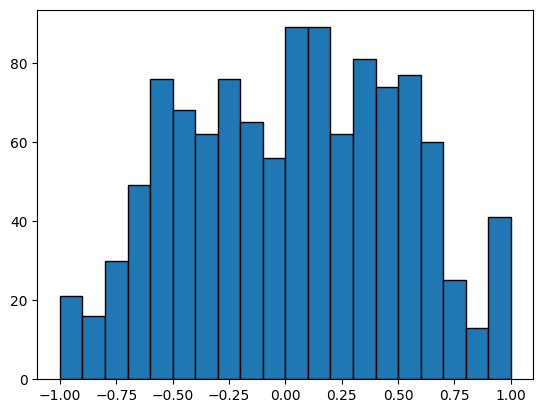

In [8]:
# Let's check distribution of our labels 
from matplotlib import pyplot as plt

frq, edges = np.histogram(Y, bins=20)
fig, ax = plt.subplots()
ax.bar(edges[:-1], frq, width=np.diff(edges), edgecolor="black", align="edge")

plt.show()

quite well distributed!

Let's save the model and test it

In [9]:
# to save model
model.save("GPS_Visual_Model_overfit", overwrite=True,include_optimizer=True,
    save_format=None, signatures=None, options=None, save_traces=True)

INFO:tensorflow:Assets written to: GPS_Visual_Model_overfit/assets


INFO:tensorflow:Assets written to: GPS_Visual_Model_overfit/assets


The model shows poor performance. It seems like drunk.


I need to collect more images(current : 1130) and balance those training set across steering angles.

### 

### Second attempt to train a model based on images generated
- 2420 images
- balanced image data(bin_size=0.05)

In [ ]:
#constants to resize image to
HEIGHT = 180
WIDTH = 320

YAW_ADJ_DEGREES = 35 # e.g. goes from -35 to +35

#get a lsit of files
mypath = '/home/winter/carla-ros-bridge/src/ros-bridge/learning_carla/GPS_and_CV/_img'
images = [f.split('.png')[0] for f in os.listdir(mypath) if f.endswith(".png")]

random.shuffle(images)

In [5]:
def balance_array(bin_start,bin_end,bin_size):
    '''
    This function returns indicies of selected elements 
    which make the training set balanced
    You need to apply the returned index to all training arrays  
    '''
    num_bins = int((bin_end - bin_start) / bin_size) + 1
    min_count = np.min(np.histogram(Y, bins=num_bins, range=(bin_start, bin_end))[0])
    balanced_array = []
    selected = []

    for start in np.arange(bin_start, bin_end, bin_size):
        end = start + bin_size
        indices = np.where((Y >= start) & (Y < end))[0]
        #balanced_array.extend(Y[indices[:min_count]])
        selected.extend(indices[:min_count])
    return selected

In [6]:
X = [] #images
X1 = [] # gen direction
Y = [] # expected steering for this image
for example in images:
    img_path = mypath+'/'+example+'.png'
    image = cv2.imread(img_path,cv2.IMREAD_COLOR)
    # option to make images smaller
    image = cv2.resize(image, (WIDTH,HEIGHT))
    
    # y labels are taken from after 2nd '_' in file name
    y = float(example.split('_')[2])
    # convert to a fraction of 90 degrees so -1 is all the way left and + 1 is all the way right
    if y >35:
        y = 35
    elif y<-35:
        y = -35
    
    y = float(y)/YAW_ADJ_DEGREES # rescale to -1 to +1 so -1 is when max left 35degrees and +1 is +35deg
    # a rough balancing by reducing number of zero steer examples
    X.append(image / 255) # adding another dimension and normalising pixels to 0-1
    # gen direction values are taken from after 1st '_' in file name
    X1.append(int(example.split('_')[1]))
    Y.append(y)

In [7]:
#convert to numpy arrays
X = np.array(X)
X1 = np.array(X1)
Y = np.array(Y)

balanced_subset = balance_array(-0.5,0.5,0.05)

X = X[balanced_subset]
X1 = X1[balanced_subset]
Y = Y[balanced_subset]

This is how training set is distributed:


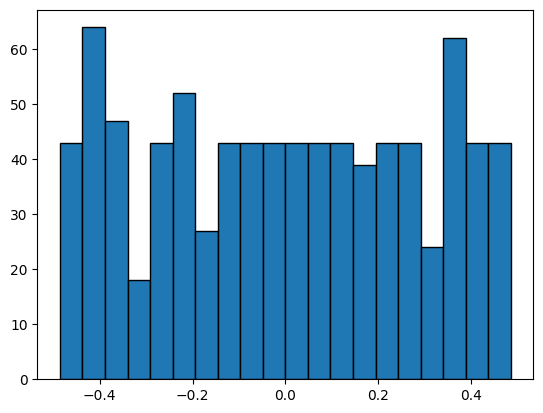

In [8]:
# draw how Y is distributed befored going into training
frq, edges = np.histogram(Y, bins=20)
fig, ax = plt.subplots()
ax.bar(edges[:-1], frq, width=np.diff(edges), edgecolor="black", align="edge")
print('This is how training set is distributed:')
plt.show()

In [9]:
def create_model():
    # Image input
    image_input = Input(shape=(HEIGHT, WIDTH, 3))
    # Integer input
    integer_input = Input(shape=(1,))
    
    # Preprocess the image input
    processed_image = Conv2D(64, kernel_size=(3, 3), activation='relu',padding='same')(image_input)
    processed_image = MaxPooling2D(pool_size=(2, 2))(processed_image)

    processed_image = Conv2D(64, kernel_size=(3, 3), activation='relu',padding='same')(processed_image)
    processed_image = MaxPooling2D(pool_size=(2, 2))(processed_image)

    processed_image = Conv2D(64, kernel_size=(3, 3), activation='relu',padding='same')(processed_image)
    processed_image = MaxPooling2D(pool_size=(2, 2))(processed_image)

    processed_image = Flatten()(processed_image)
    
    # Concatenate image features with integer input
    concatenated_inputs = Concatenate()([processed_image, integer_input])
    
    # Dense layers for prediction
    x = Dense(64, activation='relu')(concatenated_inputs)
    output = Dense(1, activation='linear')(x)
    
    # Create the model
    model = Model(inputs=[image_input, integer_input], outputs=output)
    
    return model

model = create_model()

model.summary()

2025-01-15 14:43:01.037646: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:03:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-01-15 14:43:01.038176: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/winter/.pyenv/versions/3.7.17/envs/carla-0.9.13-py3.7/lib/python3.7/site-packages/cv2/../../lib64:/home/winter/carla-ros-bridge/install/rviz_carla_plugin/lib:/home/winter/carla-ros-bridge/install/carla_waypoint_types/lib:/home/winter/carla-ros-bridge/install/carla_ros_scenario_runner_types/lib:/home/winter/carla-ros-bridge/install/carla_ackermann_msgs/lib:/home/winter/carla-ros-bridge/install/carla_msgs/lib:/opt/ros/foxy/opt/yaml_cpp_vendor/lib:/opt/ros/foxy/opt/rviz_ogre_vendor/lib:/opt/ro

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 180, 320, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 90, 160, 64)  0           ['conv2d[0][0]']                 
                                                                                              

In [10]:
model.compile(loss='MSE',
              optimizer='adam',
              metrics=['MSE'])


model.fit([X, X1], Y, batch_size=16, shuffle=False, epochs=10, validation_split=0.2)

predictions = model.predict([X,X1])
print("Prediction min: ",predictions.min()," Prediction max: ",predictions.max())

Epoch 1/10
43/43 [==============================] - 21s 415ms/step - loss: 2.0003 - MSE: 2.0003 - val_loss: 0.0087 - val_MSE: 0.0087
Epoch 2/10
43/43 [==============================] - 16s 379ms/step - loss: 0.0773 - MSE: 0.0773 - val_loss: 0.1486 - val_MSE: 0.1486
Epoch 3/10
43/43 [==============================] - 17s 386ms/step - loss: 0.0674 - MSE: 0.0674 - val_loss: 0.1713 - val_MSE: 0.1713
Epoch 4/10
43/43 [==============================] - 17s 390ms/step - loss: 0.0621 - MSE: 0.0621 - val_loss: 0.1817 - val_MSE: 0.1817
Epoch 5/10
43/43 [==============================] - 17s 389ms/step - loss: 0.0563 - MSE: 0.0563 - val_loss: 0.1890 - val_MSE: 0.1890
Epoch 6/10
43/43 [==============================] - 17s 388ms/step - loss: 0.0097 - MSE: 0.0097 - val_loss: 0.0172 - val_MSE: 0.0172
Epoch 7/10
43/43 [==============================] - 16s 374ms/step - loss: 0.0707 - MSE: 0.0707 - val_loss: 0.0380 - val_MSE: 0.0380
Epoch 8/10
43/43 [==============================] - 16s 373ms/step - 

In [11]:
# to save model
model.save("GPS_Visual_Model_biased", overwrite=True,include_optimizer=True,
    save_format=None, signatures=None, options=None, save_traces=True)

INFO:tensorflow:Assets written to: GPS_Visual_Model_balanced/assets


INFO:tensorflow:Assets written to: GPS_Visual_Model_balanced/assets


too small min_count in balanced array bring about data loss.

This may causes the biased car to the right-hand side

### Third attempt to train a model based on images generated
- 3350 images
- balanced image data(bin_size=0.3)
- regularize between -1 and 1

In [2]:
#constants to resize image to
HEIGHT = 180
WIDTH = 320

YAW_ADJ_DEGREES = 35 # e.g. goes from -35 to +35

#get a lsit of files
mypath = '/home/winter/carla-ros-bridge/src/ros-bridge/learning_carla/GPS_and_CV/_img'
images = [f.split('.png')[0] for f in os.listdir(mypath) if f.endswith(".png")]

random.shuffle(images)

In [3]:
def balance_array(bin_start,bin_end,bin_size):
    '''
    This function returns indicies of selected elements 
    which make the training set balanced
    You need to apply the returned index to all training arrays  
    '''
    num_bins = int((bin_end - bin_start) / bin_size) + 1
    min_count = np.min(np.histogram(Y, bins=num_bins, range=(bin_start, bin_end))[0])
    balanced_array = []
    selected = []

    for start in np.arange(bin_start, bin_end, bin_size):
        end = start + bin_size
        indices = np.where((Y >= start) & (Y < end))[0]
        #balanced_array.extend(Y[indices[:min_count]])
        selected.extend(indices[:min_count])
    return selected

In [4]:
X = [] #images
X1 = [] # gen direction
Y = [] #expected steering for this image
for example in images:
    img_path = mypath+'/'+example+'.png'
    image = cv2.imread(img_path,cv2.IMREAD_COLOR)
    # option to make images smaller
    image = cv2.resize(image, (WIDTH,HEIGHT))
    
    # y labels are taken from after 2nd '_' in file name
    y = float(example.split('_')[2])
    # convert to a fraction of 90 degrees so -1 is all the way left and + 1 is all the way right
    if y >35:
        y = 35
    elif y<-35:
        y = -35
    
    y = float(y)/YAW_ADJ_DEGREES # rescale to -1 to +1 so -1 is when max left 35degrees and +1 is +35deg
    X.append(image / 255) # adding another dimension and normalising pixels to 0-1
    # gen direction values are taken from after 1st '_' in file name
    X1.append(int(example.split('_')[1]))
    Y.append(y)

In [5]:
#convert to numpy arrays
X = np.array(X)
X1 = np.array(X1)
Y = np.array(Y)

balanced_subset = balance_array(-0.5,0.5,0.3) # too small min_count may affect data loss

X = X[balanced_subset]
X1 = X1[balanced_subset]
Y = Y[balanced_subset]

This is how training set is distributed:


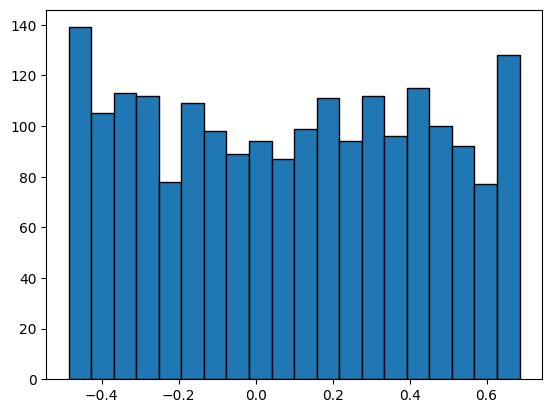

In [6]:
# draw how Y is distributed befored going into training
frq, edges = np.histogram(Y, bins=20)
fig, ax = plt.subplots()
ax.bar(edges[:-1], frq, width=np.diff(edges), edgecolor="black", align="edge")
print('This is how training set is distributed:')
plt.show()

In [7]:
from keras import regularizers
def create_model():
    # Image input
    image_input = Input(shape=(HEIGHT, WIDTH, 3))
    # Integer input
    integer_input = Input(shape=(1,))
    # Preprocess the image input
    x = Conv2D(64, kernel_size=(3, 3), activation='relu',padding='same',activity_regularizer=regularizers.L2(1e-5))(image_input)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(64, kernel_size=(3, 3), activation='relu',padding='same',activity_regularizer=regularizers.L2(1e-5))(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(64, kernel_size=(3, 3), activation='relu',padding='same',activity_regularizer=regularizers.L2(1e-5))(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dense(128, activation='relu',activity_regularizer=regularizers.L2(1e-5))(x)
    x = Dense(32, activation='relu',activity_regularizer=regularizers.L2(1e-5))(x)
    x = Dense(4, activation='relu',activity_regularizer=regularizers.L2(1e-5))(x)
    x = Flatten()(x)
    # Concatenate image features with integer input
    concatenated_inputs = Concatenate()([x, integer_input])
    # Dense layers for prediction
    output = Dense(1, activation='linear')(concatenated_inputs)
    # Create the model
    model = Model(inputs=[image_input, integer_input], outputs=output)
    return model

model = create_model()

model.summary()

2025-01-16 09:28:51.914598: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:03:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-01-16 09:28:51.914842: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/winter/.pyenv/versions/3.7.17/envs/carla-0.9.13-py3.7/lib/python3.7/site-packages/cv2/../../lib64:/home/winter/carla-ros-bridge/install/rviz_carla_plugin/lib:/home/winter/carla-ros-bridge/install/carla_waypoint_types/lib:/home/winter/carla-ros-bridge/install/carla_ros_scenario_runner_types/lib:/home/winter/carla-ros-bridge/install/carla_ackermann_msgs/lib:/home/winter/carla-ros-bridge/install/carla_msgs/lib:/opt/ros/foxy/opt/yaml_cpp_vendor/lib:/opt/ros/foxy/opt/rviz_ogre_vendor/lib:/opt/ro

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 180, 320, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 90, 160, 64)  0           ['conv2d[0][0]']                 
                                                                                              

In [8]:
model.compile(loss='MSE', optimizer='adam')
model.fit([X, X1], Y, batch_size=32, shuffle=False, epochs=10, validation_split=0.2, workers=6, use_multiprocessing=False)

predictions = model.predict([X,X1], batch_size=32)
print("Prediction min: ",predictions.min()," Prediction max: ",predictions.max())

Epoch 1/10
52/52 [==============================] - 35s 658ms/step - loss: 0.0530 - val_loss: 0.0101
Epoch 2/10
52/52 [==============================] - 34s 655ms/step - loss: 0.1268 - val_loss: 0.2960
Epoch 3/10
52/52 [==============================] - 34s 653ms/step - loss: 0.0817 - val_loss: 0.2914
Epoch 4/10
52/52 [==============================] - 35s 668ms/step - loss: 0.0809 - val_loss: 0.2878
Epoch 5/10
52/52 [==============================] - 34s 654ms/step - loss: 0.0804 - val_loss: 0.2848
Epoch 6/10
52/52 [==============================] - 33s 643ms/step - loss: 0.0801 - val_loss: 0.2824
Epoch 7/10
52/52 [==============================] - 33s 643ms/step - loss: 0.0800 - val_loss: 0.2803
Epoch 8/10
52/52 [==============================] - 34s 646ms/step - loss: 0.0799 - val_loss: 0.2786
Epoch 9/10
52/52 [==============================] - 34s 647ms/step - loss: 0.0799 - val_loss: 0.2772
Epoch 10/10
64/64 [==============================] - 11s 165ms/step
Prediction min:  -0.082

This is how predictions are distributed:


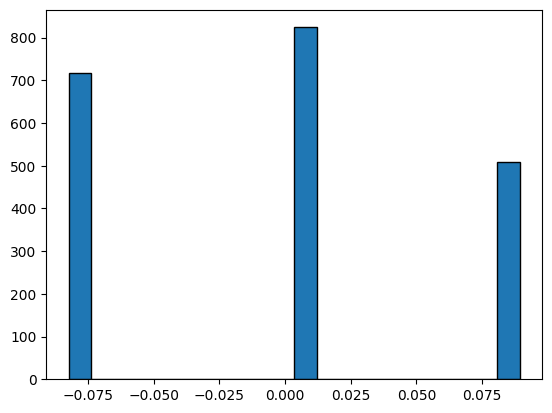

In [9]:
# draw how Predictions are distributed 
frq, edges = np.histogram(predictions, bins=20)
fig, ax = plt.subplots()
ax.bar(edges[:-1], frq, width=np.diff(edges), edgecolor="black", align="edge")
print('This is how predictions are distributed:')
plt.show()

Cool! This model is trained to predict the steering degree relatively equally.

The test result is also not bad, but I don't think that that's enough. We need to collect more huge data

In [10]:
# to save model
model.save("GPS_Visual_Model_balanced", overwrite=True,include_optimizer=True,
    save_format=None, signatures=None, options=None, save_traces=True)

INFO:tensorflow:Assets written to: GPS_Visual_Model_balanced/assets


INFO:tensorflow:Assets written to: GPS_Visual_Model_balanced/assets


### Fourth attempt same as third CV algorithm
- maintain CNN logic
- only difference is data collecting process

In [11]:
#constants to resize image to
HEIGHT = 180
WIDTH = 320

YAW_ADJ_DEGREES = 35 # e.g. goes from -35 to +35

#get a lsit of files
mypath = '/home/winter/carla-ros-bridge/src/ros-bridge/learning_carla/GPS_and_CV/_img'
images = [f.split('.png')[0] for f in os.listdir(mypath) if f.endswith(".png")]

random.shuffle(images)

In [12]:
def balance_array(bin_start,bin_end,bin_size):
    '''
    This function returns indicies of selected elements 
    which make the training set balanced
    You need to apply the returned index to all training arrays  
    '''
    num_bins = int((bin_end - bin_start) / bin_size) + 1
    min_count = np.min(np.histogram(Y, bins=num_bins, range=(bin_start, bin_end))[0])
    balanced_array = []
    selected = []

    for start in np.arange(bin_start, bin_end, bin_size):
        end = start + bin_size
        indices = np.where((Y >= start) & (Y < end))[0]
        #balanced_array.extend(Y[indices[:min_count]])
        selected.extend(indices[:min_count])
    return selected

In [13]:
X = [] #images
X1 = [] # gen direction
Y = [] #expected steering for this image
for example in images:
    img_path = mypath+'/'+example+'.png'
    image = cv2.imread(img_path,cv2.IMREAD_COLOR)
    # option to make images smaller
    image = cv2.resize(image, (WIDTH,HEIGHT))
    
    # y labels are taken from after 2nd '_' in file name
    y = float(example.split('_')[2])
    # convert to a fraction of 90 degrees so -1 is all the way left and + 1 is all the way right
    if y >35:
        y = 35
    elif y<-35:
        y = -35
    
    y = float(y)/YAW_ADJ_DEGREES # rescale to -1 to +1 so -1 is when max left 35degrees and +1 is +35deg
    X.append(image / 255) # adding another dimension and normalising pixels to 0-1
    # gen direction values are taken from after 1st '_' in file name
    X1.append(int(example.split('_')[1]))
    Y.append(y)

In [14]:
#convert to numpy arrays
X = np.array(X)
X1 = np.array(X1)
Y = np.array(Y)

balanced_subset = balance_array(-0.5,0.5,0.2) # too small min_count may affect data loss

X = X[balanced_subset]
X1 = X1[balanced_subset]
Y = Y[balanced_subset]

This is how training set is distributed:


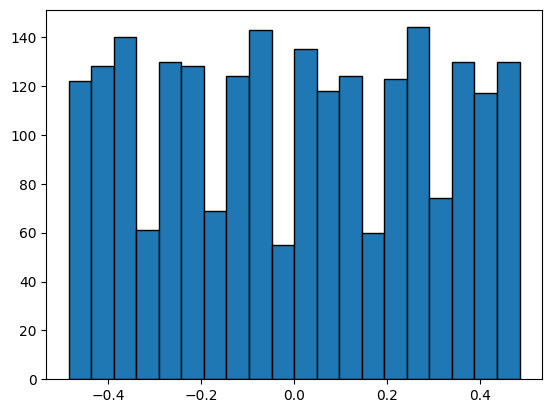

In [15]:
# draw how Y is distributed befored going into training
frq, edges = np.histogram(Y, bins=20)
fig, ax = plt.subplots()
ax.bar(edges[:-1], frq, width=np.diff(edges), edgecolor="black", align="edge")
print('This is how training set is distributed:')
plt.show()

In [16]:
from keras import regularizers
def create_model():
    # Image input
    image_input = Input(shape=(HEIGHT, WIDTH, 3))
    # Integer input
    integer_input = Input(shape=(1,))
    # Preprocess the image input
    x = Conv2D(64, kernel_size=(3, 3), activation='relu',padding='same',activity_regularizer=regularizers.L2(1e-5))(image_input)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(64, kernel_size=(3, 3), activation='relu',padding='same',activity_regularizer=regularizers.L2(1e-5))(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(64, kernel_size=(3, 3), activation='relu',padding='same',activity_regularizer=regularizers.L2(1e-5))(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dense(128, activation='relu',activity_regularizer=regularizers.L2(1e-5))(x)
    x = Dense(32, activation='relu',activity_regularizer=regularizers.L2(1e-5))(x)
    x = Dense(4, activation='relu',activity_regularizer=regularizers.L2(1e-5))(x)
    x = Flatten()(x)
    # Concatenate image features with integer input
    concatenated_inputs = Concatenate()([x, integer_input])
    # Dense layers for prediction
    output = Dense(1, activation='linear')(concatenated_inputs)
    # Create the model
    model = Model(inputs=[image_input, integer_input], outputs=output)
    return model

model = create_model()

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 180, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 180, 320, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_3 (MaxPooling2D)  (None, 90, 160, 64)  0          ['conv2d_3[0][0]']               
                                                                                            

In [17]:
model.compile(loss='MSE', optimizer='adam')
model.fit([X, X1], Y, batch_size=32, shuffle=False, epochs=10, validation_split=0.2, workers=6, use_multiprocessing=False)

predictions = model.predict([X,X1], batch_size=32)
print("Prediction min: ",predictions.min()," Prediction max: ",predictions.max())

Epoch 1/10
57/57 [==============================] - 61s 941ms/step - loss: 0.0542 - val_loss: 0.0128
Epoch 2/10
57/57 [==============================] - 51s 889ms/step - loss: 0.0629 - val_loss: 0.0743
Epoch 3/10
57/57 [==============================] - 49s 860ms/step - loss: 0.0656 - val_loss: 0.1822
Epoch 4/10
57/57 [==============================] - 46s 802ms/step - loss: 0.0576 - val_loss: 0.1905
Epoch 5/10
57/57 [==============================] - 46s 802ms/step - loss: 0.0562 - val_loss: 0.1971
Epoch 6/10
57/57 [==============================] - 46s 803ms/step - loss: 0.0552 - val_loss: 0.2023
Epoch 7/10
57/57 [==============================] - 48s 841ms/step - loss: 0.0546 - val_loss: 0.2065
Epoch 8/10
57/57 [==============================] - 47s 829ms/step - loss: 0.0542 - val_loss: 0.2098
Epoch 9/10
57/57 [==============================] - 47s 827ms/step - loss: 0.0540 - val_loss: 0.2125
Epoch 10/10
71/71 [==============================] - 17s 230ms/step
Prediction min:  -0.174

This is how predictions are distributed:


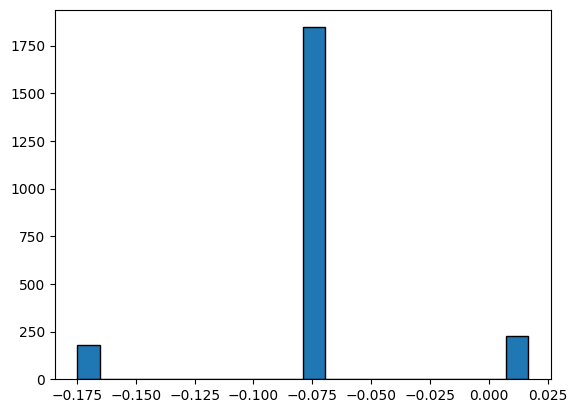

In [18]:
# draw how Predictions are distributed 
frq, edges = np.histogram(predictions, bins=20)
fig, ax = plt.subplots()
ax.bar(edges[:-1], frq, width=np.diff(edges), edgecolor="black", align="edge")
print('This is how predictions are distributed:')
plt.show()

In [19]:
# to save model
model.save("GPS_Visual_Model_over", overwrite=True,include_optimizer=True,
    save_format=None, signatures=None, options=None, save_traces=True)

INFO:tensorflow:Assets written to: GPS_Visual_Model_over/assets


INFO:tensorflow:Assets written to: GPS_Visual_Model_over/assets


### Fifth attempt to relieve overfitting
- add early Stopping
- add dropout layer
- lower learning rate

In [2]:
#constants to resize image to
HEIGHT = 180
WIDTH = 320

YAW_ADJ_DEGREES = 35 # e.g. goes from -35 to +35

#get a lsit of files
mypath = '/home/winter/carla-ros-bridge/src/ros-bridge/learning_carla/GPS_and_CV/_img'
images = [f.split('.png')[0] for f in os.listdir(mypath) if f.endswith(".png")]

random.shuffle(images)

In [3]:
def balance_array(bin_start,bin_end,bin_size):
    '''
    This function returns indicies of selected elements 
    which make the training set balanced
    You need to apply the returned index to all training arrays  
    '''
    num_bins = int((bin_end - bin_start) / bin_size) + 1
    min_count = np.min(np.histogram(Y, bins=num_bins, range=(bin_start, bin_end))[0])
    balanced_array = []
    selected = []

    for start in np.arange(bin_start, bin_end, bin_size):
        end = start + bin_size
        indices = np.where((Y >= start) & (Y < end))[0]
        #balanced_array.extend(Y[indices[:min_count]])
        selected.extend(indices[:min_count])
    return selected

In [4]:
X = [] #images
X1 = [] # gen direction
Y = [] #expected steering for this image
for example in images:
    img_path = mypath+'/'+example+'.png'
    image = cv2.imread(img_path,cv2.IMREAD_COLOR)
    # option to make images smaller
    image = cv2.resize(image, (WIDTH,HEIGHT))
    
    # y labels are taken from after 2nd '_' in file name
    y = float(example.split('_')[2])
    # convert to a fraction of 90 degrees so -1 is all the way left and + 1 is all the way right
    if y >35:
        y = 35
    elif y<-35:
        y = -35
    
    y = float(y)/YAW_ADJ_DEGREES # rescale to -1 to +1 so -1 is when max left 35degrees and +1 is +35deg
    X.append(image / 255) # adding another dimension and normalising pixels to 0-1
    # gen direction values are taken from after 1st '_' in file name
    X1.append(int(example.split('_')[1]))
    Y.append(y)

In [5]:
#convert to numpy arrays
X = np.array(X)
X1 = np.array(X1)
Y = np.array(Y)

balanced_subset = balance_array(-0.5,0.5,0.1) # too small min_count may affect data loss

X = X[balanced_subset]
X1 = X1[balanced_subset]
Y = Y[balanced_subset]

This is how training set is distributed:


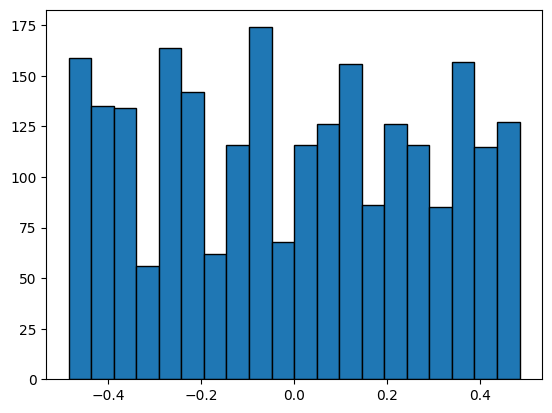

In [6]:
# draw how Y is distributed befored going into training
frq, edges = np.histogram(Y, bins=20)
fig, ax = plt.subplots()
ax.bar(edges[:-1], frq, width=np.diff(edges), edgecolor="black", align="edge")
print('This is how training set is distributed:')
plt.show()

In [7]:
from keras import regularizers
from keras.layers import Dropout
def create_model():
    # Image input
    image_input = Input(shape=(HEIGHT, WIDTH, 3))
    # Integer input
    integer_input = Input(shape=(1,))
    # Preprocess the image input
    x = Conv2D(64, kernel_size=(3, 3), activation='relu',padding='same',activity_regularizer=regularizers.L2(1e-5))(image_input)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x) # add dropout
    x = Conv2D(64, kernel_size=(3, 3), activation='relu',padding='same',activity_regularizer=regularizers.L2(1e-5))(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x) # add dropout
    x = Conv2D(64, kernel_size=(3, 3), activation='relu',padding='same',activity_regularizer=regularizers.L2(1e-5))(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x) # add dropout
    x = Dense(128, activation='relu',activity_regularizer=regularizers.L2(1e-5))(x)
    x = Dropout(0.5)(x) # add dropout
    x = Dense(32, activation='relu',activity_regularizer=regularizers.L2(1e-5))(x)
    x = Dense(4, activation='relu',activity_regularizer=regularizers.L2(1e-5))(x)
    x = Flatten()(x)
    # Concatenate image features with integer input
    concatenated_inputs = Concatenate()([x, integer_input])
    # Dense layers for prediction
    output = Dense(1, activation='linear')(concatenated_inputs)
    # Create the model
    model = Model(inputs=[image_input, integer_input], outputs=output)
    return model

model = create_model()

model.summary()

2025-01-16 16:53:30.429260: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:03:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-01-16 16:53:30.429502: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/winter/.pyenv/versions/3.7.17/envs/carla-0.9.13-py3.7/lib/python3.7/site-packages/cv2/../../lib64:/home/winter/carla-ros-bridge/install/rviz_carla_plugin/lib:/home/winter/carla-ros-bridge/install/carla_waypoint_types/lib:/home/winter/carla-ros-bridge/install/carla_ros_scenario_runner_types/lib:/home/winter/carla-ros-bridge/install/carla_ackermann_msgs/lib:/home/winter/carla-ros-bridge/install/carla_msgs/lib:/opt/ros/foxy/opt/yaml_cpp_vendor/lib:/opt/ros/foxy/opt/rviz_ogre_vendor/lib:/opt/ro

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 180, 320, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 90, 160, 64)  0           ['conv2d[0][0]']                 
                                                                                              

In [13]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
model.compile(loss='MSE', optimizer='adam')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True) # patience=5
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001) # patience=2
model.fit([X,X1], Y, batch_size=64, shuffle=False, epochs=100, validation_split=0.2, callbacks=[early_stopping, reduce_lr]) # reduce_lr

predictions = model.predict([X,X1], batch_size=32)
print("Prediction min: ",predictions.min()," Prediction max: ",predictions.max())

Epoch 1/100
31/31 [==============================] - 58s 2s/step - loss: 0.0543 - val_loss: 0.2137 - lr: 0.0010
Epoch 2/100
31/31 [==============================] - 45s 1s/step - loss: 0.0528 - val_loss: 0.2148 - lr: 0.0010
Epoch 3/100
31/31 [==============================] - 45s 1s/step - loss: 0.0527 - val_loss: 0.2156 - lr: 0.0010
Epoch 4/100
31/31 [==============================] - 46s 1s/step - loss: 0.0520 - val_loss: 0.2158 - lr: 2.0000e-04
Epoch 5/100
31/31 [==============================] - 45s 1s/step - loss: 0.0520 - val_loss: 0.2159 - lr: 2.0000e-04
Epoch 6/100
31/31 [==============================] - 45s 1s/step - loss: 0.0519 - val_loss: 0.2160 - lr: 4.0000e-05


: 

This is how predictions are distributed:


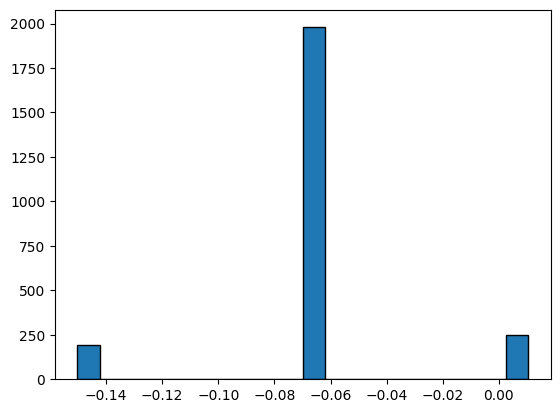

In [12]:
# draw how Predictions are distributed 
frq, edges = np.histogram(predictions, bins=20)
fig, ax = plt.subplots()
ax.bar(edges[:-1], frq, width=np.diff(edges), edgecolor="black", align="edge")
print('This is how predictions are distributed:')
plt.show()

In [ ]:
# to save model
model.save("GPS_Visual_Model_over", overwrite=True,include_optimizer=True,
    save_format=None, signatures=None, options=None, save_traces=True)